Use this notebook to produce table and figure for the Research Data section of the write-up.

Table 1. List of 129 stocks  
Table 2. Description of historical data attributes  
Table 3. Summary statistics of technical indicator values  
Table 4. List of dates the SET100 index were updated and the constituent list published  
Table 5. List of stocks added and removed at each index update.  
Table 6. Description of stock tickers that no longer exists.  
Table 7. Observation count of each stock time series.  

In [1]:
import sys, os, os.path
if not 'EXPERIMENT_HOME' in os.environ: # Configure local paths if not already defined
    ML_HOME = os.path.abspath(os.path.join("/home/jovyan", "ml_home")) # ML workspace
    EXPERIMENT_HOME = os.path.abspath(os.path.join(ML_HOME, "..")) # Experiment workspace
    DATA_HOME = os.path.abspath(os.path.join(EXPERIMENT_HOME,"dataset")) # Dataset location
    os.environ["EXPERIMENT_HOME"] = EXPERIMENT_HOME
    os.environ["DATA_HOME"] = DATA_HOME
    sys.path.insert(0, EXPERIMENT_HOME)
    sys.path.insert(0, ML_HOME) # Add to path so can load our library
    os.chdir(EXPERIMENT_HOME) # Change working directory to experiment workspace
print("Experiment Home: ", os.path.abspath(os.curdir), "; Data Home:", DATA_HOME)

Experiment Home:  /home/jovyan ; Data Home: /home/jovyan/dataset


In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime as dt
import xlrd
import matplotlib.pyplot as plt
%matplotlib inline

Get stocks in the dataset folder. The stocks are indexed in _directory.csv.

In [3]:
os.chdir("/home/jovyan/dataset/set100.data")
stocks = pd.read_csv('_directory.csv', index_col=0)
print("Stocks count:", len(stocks))
stocks.tail()

Stocks count: 150


,company_name,industry,sector,symbol
ticker,,,,
VIBHA,VIBHAVADI MEDICAL CENTER PUBLIC COMPANY LIMITED,Services,Health Care Services,VIBHA
VNG,VANACHAI GROUP PUBLIC COMPANY LIMITED,Property & Construction,Construction Materials,VNG
WHA,WHA CORPORATION PUBLIC COMPANY LIMITED,Property & Construction,Property Development,WHA
WHAUP,WHA UTILITIES AND POWER PUBLIC COMPANY LIMITED,Resources,Energy & Utilities,WHAUP
WORK,WORKPOINT ENTERTAINMENT PUBLIC COMPANY LIMITED,Services,Media & Publishing,WORK


Construct an in-memory dataframe containing all stocks time-series.

In [4]:
period_start='2015-01-01'
period_end='2019-12-31'
series = {}

# Set index for data series to the date column
# Add column ticker, sector, industry, observation count 
#   to each data series and combine to single dictionary
for s in stocks.symbol.values:
    df = pd.read_csv("%s.csv" % s, index_col=0)
    df.loc[:,('Date')] = df.index
    df['Ticker'] = s
    sector = stocks[stocks['symbol']==s].sector.values[0]
    df['Sector'] = sector
    industry = stocks[stocks['symbol']==s].industry.values[0]
    df['Industry'] = industry
    df['Observations'] = len(df)
    series[s] = df[period_start:period_end]
# The dictionary 'series' contains time-series with key ticker.
# Stack dataframes together as one dataframe.
rows = []
for k, d in series.items():
    rows.append(d)
df = pd.concat(rows, ignore_index=True)

In [5]:
# Pivot table: Value=Observations; the number of data observations for the stock.
ptable = df.pivot_table(values='Observations', index='Date', columns=['Industry', 'Sector', 'Ticker'])
ptable.tail()

Industry   Agro & Food Industry                                          \
Sector             Agribusiness         Food & Beverage                   
Ticker                     GFPT     STA             CBG     CPF    ICHI   
Date                                                                      
2019-12-25               1596.0  1596.0          1596.0  1596.0  1596.0   
2019-12-26               1596.0  1596.0          1596.0  1596.0  1596.0   
2019-12-27               1596.0  1596.0          1596.0  1596.0  1596.0   
2019-12-30               1596.0  1596.0          1596.0  1596.0  1596.0   
2019-12-31               1596.0  1596.0          1596.0  1596.0  1596.0   

Industry                                           ...            Technology  \
Sector                                             ... Electronic Components   
Ticker        KTIS       M   MALEE    MINT    OSP  ...                   SVI   
Date                                               ...                         
2019-12-25  1596.0  1596.0  1596.0  1596.0  522.0  ...                1596.0   
2019-12-26  1596.0  1596.0  1596.0  1596.0  522.0  ...                1596.0   
2019-12-27  1596.0  1596.0  1596.0  1596.0  522.0  ...                1596.0   
2019-12-30  1596.0  1596.0  1596.0  1596.0  522.0  ...                1596.0   
2019-12-31  1596.0  1596.0  1596.0  1596.0  522.0  ...                1596.0   

Industry                                                                   \
Sector     Information & Communication Technology                           
Ticker                                     ADVANC    DTAC  INTUCH     JAS   
Date                                                                        
2019-12-25                                 1596.0  1596.0  1596.0  1596.0   
2019-12-26                                 1596.0  1596.0  1596.0  1596.0   
2019-12-27                                 1596.0  1596.0  1596.0  1596.0   
2019-12-30                                 1596.0  1596.0  1596.0  1596.0   
2019-12-31                                 1596.0  1596.0  1596.0  1596.0   

Industry                                            
Sector                                              
Ticker       JMART  SAMART  SAMTEL   THCOM    TRUE  
Date                                                
2019-12-25  1596.0  1596.0  1596.0  1596.0  1596.0  
2019-12-26  1596.0  1596.0  1596.0  1596.0  1596.0  
2019-12-27  1596.0  1596.0  1596.0  1596.0  1596.0  
2019-12-30  1596.0  1596.0  1596.0  1596.0  1596.0  
2019-12-31  1596.0  1596.0  1596.0  1596.0  1596.0  

[5 rows x 150 columns]

In [6]:
# Observations count at last date of the dataset.
table_7 = ptable['2019-12-31':].T
table_7

Date                                                                2019-12-31
Industry             Sector                                 Ticker            
Agro & Food Industry Agribusiness                           GFPT        1596.0
                                                            STA         1596.0
                     Food & Beverage                        CBG         1596.0
                                                            CPF         1596.0
                                                            ICHI        1596.0
...                                                                        ...
Technology           Information & Communication Technology JMART       1596.0
                                                            SAMART      1596.0
                                                            SAMTEL      1596.0
                                                            THCOM       1596.0
                                                            TRUE        1596.0

[150 rows x 1 columns]

In [8]:
table_7.to_csv('table_7.csv')

In [7]:

# table = df.pivot(columns='Ticker')['Observations'] # Pivot table
# table

# table_7.pivot()['Ticker']

In [15]:
# output = os.path.join(os.environ['EXPERIMENT_HOME'],'tables','table_7')
# table_7.to_csv(output)

# table_7[['Ticker']].index
table_7.columns

Index(['2019-12-31'], dtype='object', name='Date')

Text(0.5, 1.0, 'SET100 Stocks: Closing price observations during 2015-2019')

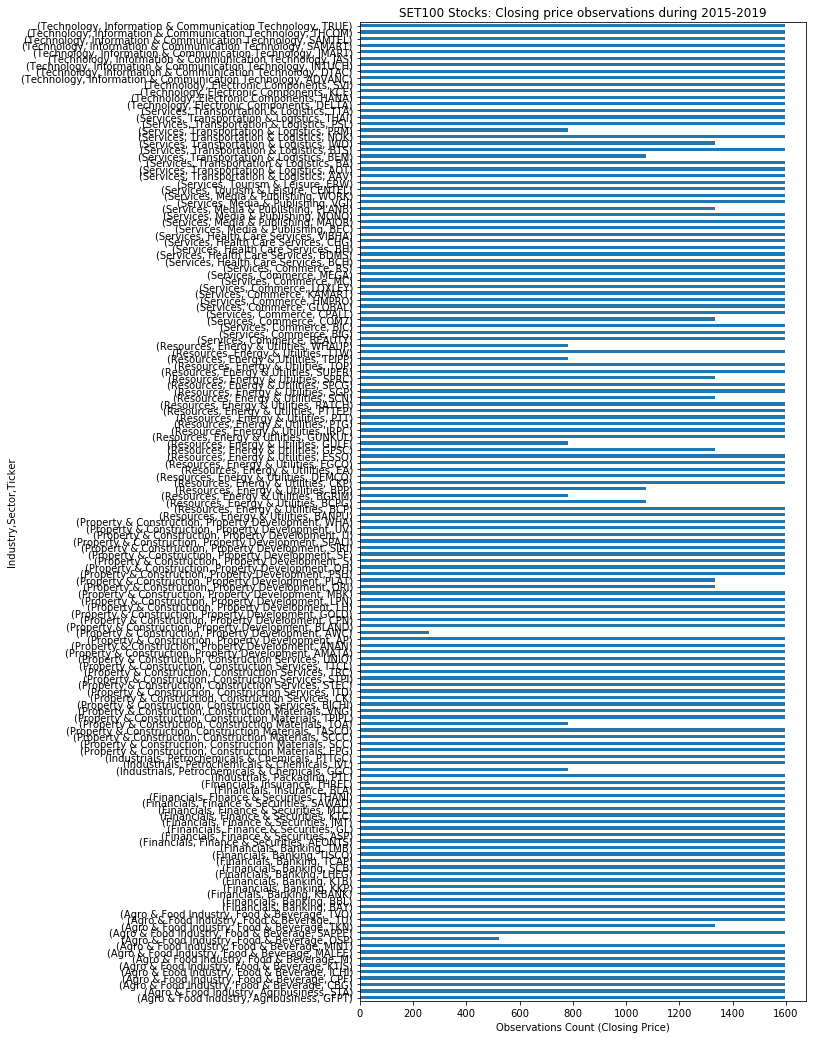

In [23]:
# Get ticker from multiindex.
# tickers = np.array([i[2] for i in table_7.index.values])

fig, ax = plt.subplots(figsize=(8,18))
table_7.plot.barh(ax=ax, legend=False) # , xticks=tickers to change ticker

ax.tick_params(axis='y', which='major', labelsize=10)
ax.tick_params(axis='y', which='minor', labelsize=8)
plt.xlabel('Observations Count (Closing Price)')
plt.title("SET100 Stocks: Closing price observations during 2015-2019")